# Train some models on the features extracted from InceptionV3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.xception import Xception
from keras.preprocessing import image
#from keras.models import Model
#from keras.layers import GlobalAveragePooling2D

# #Default InceptionV3 options:
# #https://keras.io/applications/#inceptionv3
#
# For pre-trained weights, input_shape has to be  (299, 299, 3) (with 'channels_last' data format)
# or (3, 299, 299) (with 'channels_first' data format).
#
# Note that image.load_img() uses 'channels_last' by default, and you need to
# specify target_size = (299,299) when loading an image to feed into InceptionV3.
#
# keras.applications.inception_v3.InceptionV3(include_top=True
#                                             , weights='imagenet'
#                                             , input_tensor=None
#                                             , input_shape=None
#                                             , pooling=None
#                                             , classes=1000)

import os
from PIL import Image
#Hash images using the ImageHash library
#https://pypi.python.org/pypi/ImageHash
import imagehash

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [353]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [188]:
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

## Functions to wrap confusion matrix in a dataframe and print metrics for classifiers

In [204]:
def confusion_df(y_true, y_pred, sklearn_model):
    return pd.DataFrame(confusion_matrix(y_true, y_pred),
                           index=['Actual {}'.format(label) for label in sklearn_model.classes_],
                           columns=['Predicted {}'.format(label) for label in sklearn_model.classes_])

In [372]:
def print_classifier_metrics(X_train, X_test, y_train, y_test, sklearn_model):
    y_pred_train = sklearn_model.predict_proba(X_train)
    y_pred_test = sklearn_model.predict_proba(X_test)
    
    print("Train log_loss: {}, Test log_loss: {}".format(
        log_loss(y_train, y_pred_train), log_loss(y_test, y_pred_test)))

    y_pred_train_cat = sklearn_model.predict(X_train)
    y_pred_test_cat = sklearn_model.predict(X_test)
    print("Train accuracy: {}, Test accuracy: {}".format(
            accuracy_score(y_train, y_pred_train_cat),
            accuracy_score(y_test, y_pred_test_cat))
         )

## Load the data and pull out features and labels

In [6]:
tree_features_df = pd.read_csv('data/tree_images.csv', '|', index_col=0)
tree_features_df.head()

,p_hash,filename,species,tags,incv3_out_0,incv3_out_1,incv3_out_2,incv3_out_3,incv3_out_4,incv3_out_5,...,incv3_out_2038,incv3_out_2039,incv3_out_2040,incv3_out_2041,incv3_out_2042,incv3_out_2043,incv3_out_2044,incv3_out_2045,incv3_out_2046,incv3_out_2047
0,99a7465a1e99acb4,image_picea_sitchensis_27.png,picea_sitchensis,NaN,13.995308,1.316715,0.279829,67.839417,43.733177,38.206165,...,160.387985,1.176492,45.983730,10.465877,22.118896,3.226861,29.401524,0.486684,0.000000,15.634432
1,93d12f8e712ef068,image_picea_sitchensis_33.png,picea_sitchensis,NaN,7.449574,0.417233,0.447665,6.178374,2.092985,6.251201,...,2.649559,0.523397,0.392520,7.703988,13.842188,12.907540,1.112756,0.000000,5.436511,1.154409
2,cce3482eb991533b,image_picea_sitchensis_6.png,picea_sitchensis,NaN,0.708871,0.640444,1.305804,9.565918,15.157275,1.787687,...,15.114614,0.000000,0.066235,2.280773,8.082823,1.939496,0.041136,0.000000,0.000000,0.034437
3,c119991c4fcf1cda,image_picea_sitchensis_in_winter_12.png,picea_sitchensis,NaN,7.138457,1.225646,15.940742,42.644821,23.604031,13.818824,...,49.895081,0.000000,7.600242,3.260593,13.135204,12.249097,17.588070,0.000000,0.000000,0.000000
4,e3c3dab100fdc29c,image_sitka_spruce_59.png,picea_sitchensis,NaN,0.030419,2.616714,1.435360,52.145359,5.377345,5.631077,...,13.391465,21.970516,5.217728,8.282942,0.788009,0.591635,35.845409,0.000000,0.000000,2.780651


In [8]:
X = tree_features_df.drop(['p_hash', 'filename', 'species','tags'],axis=1)
X.head()

,incv3_out_0,incv3_out_1,incv3_out_2,incv3_out_3,incv3_out_4,incv3_out_5,incv3_out_6,incv3_out_7,incv3_out_8,incv3_out_9,...,incv3_out_2038,incv3_out_2039,incv3_out_2040,incv3_out_2041,incv3_out_2042,incv3_out_2043,incv3_out_2044,incv3_out_2045,incv3_out_2046,incv3_out_2047
0,13.995308,1.316715,0.279829,67.839417,43.733177,38.206165,0.000000,80.229782,43.556065,17.829075,...,160.387985,1.176492,45.983730,10.465877,22.118896,3.226861,29.401524,0.486684,0.000000,15.634432
1,7.449574,0.417233,0.447665,6.178374,2.092985,6.251201,0.772362,1.633119,2.435113,9.189584,...,2.649559,0.523397,0.392520,7.703988,13.842188,12.907540,1.112756,0.000000,5.436511,1.154409
2,0.708871,0.640444,1.305804,9.565918,15.157275,1.787687,0.532695,0.937607,2.542537,18.555613,...,15.114614,0.000000,0.066235,2.280773,8.082823,1.939496,0.041136,0.000000,0.000000,0.034437
3,7.138457,1.225646,15.940742,42.644821,23.604031,13.818824,1.012441,70.799576,18.526180,16.013214,...,49.895081,0.000000,7.600242,3.260593,13.135204,12.249097,17.588070,0.000000,0.000000,0.000000
4,0.030419,2.616714,1.435360,52.145359,5.377345,5.631077,0.888996,59.129547,13.564379,28.716227,...,13.391465,21.970516,5.217728,8.282942,0.788009,0.591635,35.845409,0.000000,0.000000,2.780651


In [388]:
# y = pd.get_dummies(tree_features_df['species'])
# y.head()

In [17]:
y = tree_features_df['species']
y.head()

0    picea_sitchensis
1    picea_sitchensis
2    picea_sitchensis
3    picea_sitchensis
4    picea_sitchensis
Name: species, dtype: object

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1014 entries, 0 to 1013
Columns: 2048 entries, incv3_out_0 to incv3_out_2047
dtypes: float64(2048)
memory usage: 15.9 MB


In [19]:
y.describe()

count                 1014
unique                   3
top       acer_macrophylum
freq                   370
Name: species, dtype: object

## Get a train-test split of the data

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=359)

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 304 to 996
Columns: 2048 entries, incv3_out_0 to incv3_out_2047
dtypes: float64(2048)
memory usage: 12.7 MB


In [22]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 264 to 747
Columns: 2048 entries, incv3_out_0 to incv3_out_2047
dtypes: float64(2048)
memory usage: 3.2 MB


## Try logistic regression using one vs. rest (i.e. 3 separate logistic regressions)

Looks like we need lots of regularization since there are so many features

In [90]:
#log_model = LogisticRegression(multi_class='multinomial', solver='saga', C=0.5, max_iter=1000)
log_model = LogisticRegression(multi_class='ovr', solver='liblinear', C=0.00001, max_iter=1000)

In [91]:
log_model.fit(X_train, y_train)

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [92]:
y_test_hat = log_model.predict_proba(X_test)

In [93]:
y_test_hat[:10]

array([[ 0.54860134,  0.22469948,  0.22669918],
       [ 0.44574158,  0.25163863,  0.30261979],
       [ 0.33414079,  0.2790197 ,  0.38683951],
       [ 0.41732966,  0.23454815,  0.34812219],
       [ 0.40272523,  0.33680587,  0.26046889],
       [ 0.2997952 ,  0.38809015,  0.31211465],
       [ 0.47448854,  0.22082997,  0.30468148],
       [ 0.45033394,  0.42345365,  0.12621241],
       [ 0.37153535,  0.56208182,  0.06638283],
       [ 0.45625385,  0.11013843,  0.43360772]])

In [63]:
y_test_true = pd.get_dummies(y_test)
y_test_true.head(10)

,acer_macrophylum,picea_sitchensis,platanus_acerifolia
264,0,1,0
987,1,0,0
782,1,0,0
778,1,0,0
286,0,1,0
481,0,0,1
156,0,1,0
107,0,1,0
19,0,1,0
349,0,0,1


In [94]:
#1.88 with C=0.01
#1.17 with C=0.001
#0.987 with C=0.0001
#0.984 with C=0.00001
log_loss(y_test, y_test_hat)

0.98397553264916515

In [95]:
y_test_pred_cat = log_model.predict(X_test)

In [96]:
#about 0.48 with C=0.001 or C=0.01
#0.49 with C=0.0001
#0.502 with C=0.00001
accuracy_score(y_test, y_test_pred_cat)

0.50246305418719217

In [389]:
print_classifier_metrics(X_train, X_test, y_train, y_test, log_model)

Train log_loss: 0.9137256601243977, Test log_loss: 0.9839755326491652
Train accuracy: 0.5955610357583231, Test accuracy: 0.5024630541871922


## Try logistic regression with multinomial probabilities

Note: The solver doesn't converge if the regularization is too weak.

Looks like we get a slight improvement over the one vs. rest scheme.  Looks like the best C is around 0.00001

In [346]:
log_model_multi = LogisticRegression(multi_class='multinomial', solver='sag', 
                                     class_weight='balanced', C=0.00001, max_iter=1000)

In [347]:
log_model_multi.fit(X_train, y_train)

LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

In [348]:
y_test_hat_multi = log_model_multi.predict_proba(X_test)
y_train_hat_multi = log_model_multi.predict_proba(X_train)

In [349]:
#0.97799 with C=0.00005
#0.9783598 with C=0.00001
#0.97673232346677019 with class_weight='balanced', C=0.00001
#0.9891089 with C=0.000005
#1.021896  with C=0.000001
#log_loss(y_test, y_test_hat_multi)

print("Train log loss: {}, Test log loss: {}".format(
    log_loss(y_train, y_train_hat_multi), log_loss(y_test, y_test_hat_multi)))

Train log loss: 0.8847529706149773, Test log loss: 0.9767302988253657


In [350]:
y_test_pred_cat_multi = log_model_multi.predict(X_test)
y_train_pred_cat_multi = log_model_multi.predict(X_train)

In [351]:
#0.517 with C=0.00005
#0.522 with C=0.00001
#0.51231527093596063 with class_weight='balanced', C=0.00001
#0.517 with C=0.000005
#0.4926 with C=0.000001
#accuracy_score(y_test, y_test_pred_cat_multi)

print("Train accuracy: {}, Test accuracy: {}".format(
        accuracy_score(y_train, y_train_pred_cat_multi),
        accuracy_score(y_test, y_test_pred_cat_multi))
     )

Train accuracy: 0.6078914919852034, Test accuracy: 0.5123152709359606


In [390]:
print_classifier_metrics(X_train, X_test, y_train, y_test, log_model_multi)

Train log_loss: 0.8847529706149773, Test log_loss: 0.9767302988253657
Train accuracy: 0.6078914919852034, Test accuracy: 0.5123152709359606


In [193]:
log_model_multi.classes_

array(['acer_macrophylum', 'picea_sitchensis', 'platanus_acerifolia'], dtype=object)

### Confusion matrix for multilomial logistic regression

In [222]:
confusion_df(y_test, y_test_pred_cat_multi, log_model_multi)

,Predicted acer_macrophylum,Predicted picea_sitchensis,Predicted platanus_acerifolia
Actual acer_macrophylum,37,21,19
Actual picea_sitchensis,22,36,10
Actual platanus_acerifolia,16,11,31


## Try a random forest

This isn't doing as well as logistic regression. I haven't tried pre-pruning the trees, though.

In [181]:
rf_model = RandomForestClassifier(n_estimators=150, max_depth=7, oob_score=True, n_jobs=-1, random_state=25)

In [182]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=25, verbose=0, warm_start=False)

In [208]:
#1.0255954030874306 with n_estimators=50 (seed=359)
#1.0078875073836353 with n_estimators=100 (seed=359)
#0.99548093251202763 with n_estimators=125 (seed=90)
#0.99277943264842983 with n_estimators=150, max_depth=10 (seed=90)
#0.99532292044623072 with n_estimators=150, max_depth=7 (seed=25)
#1.0060613930521483 with n_estimators=150 (seed=359)
#1.0066156011904319 with n_estimators=200 (seed=359)
y_test_hat = rf_model.predict_proba(X_test)
log_loss(y_test, y_test_hat)

0.99532292044623072

In [209]:
#0.41871921182266009 with n_estimators=50 (seed=359)
#0.41379310344827586 with n_estimators=100 (seed=359)
#0.45320197044334976 with n_estimators=125 (seed=90) 
#0.47290640394088668 with n_estimators=150, max_depth=10 (seed=90)
#0.48768472906403942 with n_estimators=150, max_depth=7 (seed=25)
#0.45320197044334976 with n_estimators=150 (seed=359)
#0.45320197044334976 with n_estimators=200 (seed=359)
y_test_hat_cat = rf_model.predict(X_test)
accuracy_score(y_test, y_test_hat_cat)

0.48768472906403942

In [210]:
rf_model.oob_score_

0.4722564734895191

In [373]:
print_classifier_metrics(X_train, X_test, y_train, y_test, rf_model)

Train log_loss: 0.5106429453118635, Test log_loss: 0.9953229204462307
Train accuracy: 0.9876695437731196, Test accuracy: 0.4876847290640394


### Confusion matrix for random forest

In [211]:
confusion_df(y_test, y_test_hat_cat, rf_model)

,Predicted acer_macrophylum,Predicted picea_sitchensis,Predicted platanus_acerifolia
Actual acer_macrophylum,46,13,18
Actual picea_sitchensis,31,24,13
Actual platanus_acerifolia,24,5,29


## Try a Gradient Booster

This is the best so far, with the right parameters... also the slowest to train

In [172]:
gb_model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, subsample=0.5, max_depth=5)

In [173]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [363]:
#0.9469096393142834 with learning_rate=0.01, n_estimators=200, subsample=0.5, max_depth=5 (Best so far)
#0.98792578185982549 with learning_rate=0.01, n_estimators=200, subsample=0.5, max_depth=3
#1.0309311779727697 with learning_rate=0.1, n_estimators=100, subsample=0.5, max_depth=3
y_test_hat = gb_model.predict_proba(X_test)
y_train_hat = gb_model.predict_proba(X_train)
print("Train log loss: {}, Test log loss: {}".format(log_loss(y_train, y_train_hat), log_loss(y_test, y_test_hat)))

Train log loss: 0.4147540448728718, Test log loss: 0.9469096393142834


In [364]:
#0.54679802955665024 with learning_rate=0.01, n_estimators=200, subsample=0.5, max_depth=5 (Best so far)
#0.47290640394088668 with learning_rate=0.01, n_estimators=200, subsample=0.5, max_depth=3
#0.47290640394088668 with learning_rate=0.1, n_estimators=100, subsample=0.5, max_depth=3
y_test_hat_cat = gb_model.predict(X_test)
y_train_hat_cat = gb_model.predict(X_train)
print("Train accuracy: {}, Test accuracy: {}".format(
        accuracy_score(y_train, y_train_hat_cat),
        accuracy_score(y_test, y_test_hat_cat))
     )

Train accuracy: 0.998766954377312, Test accuracy: 0.5467980295566502


In [374]:
print_classifier_metrics(X_train, X_test, y_train, y_test, gb_model)

Train log_loss: 0.4147540448728718, Test log_loss: 0.9469096393142834
Train accuracy: 0.998766954377312, Test accuracy: 0.5467980295566502


In [214]:
gb_model.classes_

array(['acer_macrophylum', 'picea_sitchensis', 'platanus_acerifolia'], dtype=object)

In [315]:
gb_model.alpha

0.9

### Confusion matrix for gradient booster

In [365]:
confusion_df(y_test, y_test_hat_cat, gb_model)

,Predicted acer_macrophylum,Predicted picea_sitchensis,Predicted platanus_acerifolia
Actual acer_macrophylum,46,17,14
Actual picea_sitchensis,26,30,12
Actual platanus_acerifolia,18,5,35


## Try a Support Vector Classifier

In [262]:
# le = LabelEncoder()
# le.fit(y)

# y_enc = le.transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y_enc)

In [298]:
svc_model = SVC(kernel='linear', C=1.0, probability=True)

In [317]:
svc_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [318]:
y_train_pred = svc_model.predict(X_train)
y_test_pred = svc_model.predict(X_test)

In [319]:
accuracy_score(y_train, y_train_pred)

1.0

In [320]:
accuracy_score(y_test, y_test_pred)

0.49753694581280788

In [321]:
y_train_prob_pred = svc_model.predict_proba(X_train)
y_test_prob_pred = svc_model.predict_proba(X_test)

In [322]:
log_loss(y_test, y_test_prob_pred)

1.0182313270802499

In [323]:
log_loss(y_train, y_train_prob_pred)

0.74002248124947478

In [375]:
print_classifier_metrics(X_train, X_test, y_train, y_test, svc_model)

Train log_loss: 0.7400224812494748, Test log_loss: 1.0182313270802499
Train accuracy: 1.0, Test accuracy: 0.4975369458128079


In [325]:
Counter(y_test_pred)

Counter({'acer_macrophylum': 91,
         'picea_sitchensis': 58,
         'platanus_acerifolia': 54})

In [326]:
Counter(y_test)

Counter({'acer_macrophylum': 77,
         'picea_sitchensis': 68,
         'platanus_acerifolia': 58})

In [327]:
list(zip(y_test, y_test_pred))[:10]

[('picea_sitchensis', 'acer_macrophylum'),
 ('acer_macrophylum', 'acer_macrophylum'),
 ('acer_macrophylum', 'acer_macrophylum'),
 ('acer_macrophylum', 'acer_macrophylum'),
 ('picea_sitchensis', 'acer_macrophylum'),
 ('platanus_acerifolia', 'platanus_acerifolia'),
 ('picea_sitchensis', 'picea_sitchensis'),
 ('picea_sitchensis', 'acer_macrophylum'),
 ('picea_sitchensis', 'picea_sitchensis'),
 ('platanus_acerifolia', 'acer_macrophylum')]

### Confusion matrix for SVM

In [328]:
confusion_df(y_test,y_test_pred,svc_model)

,Predicted acer_macrophylum,Predicted picea_sitchensis,Predicted platanus_acerifolia
Actual acer_macrophylum,43,17,17
Actual picea_sitchensis,25,32,11
Actual platanus_acerifolia,23,9,26


## Try Naive Bayes

In [378]:
nb_model = MultinomialNB(fit_prior=True)
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [379]:
y_train_hat = nb_model.predict_proba(X_train)
y_test_hat = nb_model.predict_proba(X_test)
print("Train log loss: {}, Test log loss: {}".format(log_loss(y_train, y_train_hat), log_loss(y_test, y_test_hat)))

Train log loss: 19.068092214451486, Test log loss: 18.16577272577269


In [380]:
y_train_hat_cat = nb_model.predict(X_train)
y_test_hat_cat = nb_model.predict(X_test)
print("Train accuracy: {}, Test accuracy: {}".format(
        accuracy_score(y_train, y_train_hat_cat),
        accuracy_score(y_test, y_test_hat_cat))
     )

Train accuracy: 0.436498150431566, Test accuracy: 0.4630541871921182


In [381]:
print_classifier_metrics(X_train, X_test, y_train, y_test, nb_model)

Train log_loss: 19.068092214451486, Test log_loss: 18.16577272577269
Train accuracy: 0.436498150431566, Test accuracy: 0.4630541871921182


In [362]:
confusion_df(y_test,y_test_pred,nb_model)

,Predicted acer_macrophylum,Predicted picea_sitchensis,Predicted platanus_acerifolia
Actual acer_macrophylum,43,17,17
Actual picea_sitchensis,25,32,11
Actual platanus_acerifolia,23,9,26


## Show misclassified images vs. correctly classified images

In [224]:
(y_test != y_test_hat_cat).sum()

92

In [225]:
(y_test == y_test_hat_cat).sum()

111

In [227]:
(y_test != y_test_hat_cat)[:10]

264     True
987    False
782     True
778    False
286     True
481     True
156     True
107     True
19     False
349    False
Name: species, dtype: bool

In [232]:
tree_features_df[['p_hash', 'filename', 'species']][:10]

,p_hash,filename,species
0,99a7465a1e99acb4,image_picea_sitchensis_27.png,picea_sitchensis
1,93d12f8e712ef068,image_picea_sitchensis_33.png,picea_sitchensis
2,cce3482eb991533b,image_picea_sitchensis_6.png,picea_sitchensis
3,c119991c4fcf1cda,image_picea_sitchensis_in_winter_12.png,picea_sitchensis
4,e3c3dab100fdc29c,image_sitka_spruce_59.png,picea_sitchensis
5,84522fbc57bd21a9,image_sitka_spruce_65.png,picea_sitchensis
6,ff6042c59f3870e2,image_sitka_spruce_71.png,picea_sitchensis
7,aeae42b4fa96050f,image_sitka_spruce_cones_58.png,picea_sitchensis
8,fb90080905fe47bf,image_sitka_spruce_cones_70.png,picea_sitchensis
9,85563edad4258b66,image_sitka_spruce_cones_64.png,picea_sitchensis


In [242]:
y_test.index

Int64Index([ 264,  987,  782,  778,  286,  481,  156,  107,   19,  349,
            ...
               7, 1002,   16,  653,  799,   21,  682,  261,  358,  747],
           dtype='int64', length=203)

In [247]:
incorrect_idx = y_test.index[np.where(y_test != y_test_hat_cat)]
correct_idx = y_test.index[np.where(y_test == y_test_hat_cat)]

In [248]:
misclassified_df = tree_features_df.loc[incorrect_idx, ['p_hash', 'filename', 'species']]
correct_df = tree_features_df.loc[correct_idx, ['p_hash', 'filename', 'species']]

In [249]:
misclassified_df.head()

,p_hash,filename,species
264,94e1781e6343cfc9,image_sitka_spruce_cones_53.png,picea_sitchensis
782,f0d6e110ae0baf6a,image_bigleaf_maple_47.png,acer_macrophylum
286,9899c762d66b5a70,image_sitka_spruce_cones_81.png,picea_sitchensis
481,874c3843899eb6e7,image_platanus_acerifolia_56.png,platanus_acerifolia
156,d0073ecfd922232f,image_sitka_spruce_16.png,picea_sitchensis


In [250]:
correct_df.head()

,p_hash,filename,species
987,9393394a8e36a7c5,image_acer_macrophylum_seeds_61.png,acer_macrophylum
778,d0e53f5a658cf442,image_bigleaf_maple_84.png,acer_macrophylum
19,c4b674c978c5174e,image_picea_sitchensis_26.png,picea_sitchensis
349,bde8f86321a9d072,image_platanus_acerifolia_fruit_91.png,platanus_acerifolia
931,9d852d9df5252d22,image_acer_macrophylum_in_winter_89.png,acer_macrophylum


In [395]:
misclassified_df.loc[264, 'filename']

'image_sitka_spruce_cones_53.png'

In [397]:
tree_features_df.loc[incorrect_idx].head()

,p_hash,filename,species,tags,incv3_out_0,incv3_out_1,incv3_out_2,incv3_out_3,incv3_out_4,incv3_out_5,...,incv3_out_2038,incv3_out_2039,incv3_out_2040,incv3_out_2041,incv3_out_2042,incv3_out_2043,incv3_out_2044,incv3_out_2045,incv3_out_2046,incv3_out_2047
264,94e1781e6343cfc9,image_sitka_spruce_cones_53.png,picea_sitchensis,NaN,1.172103,0.157195,14.754305,61.848797,2.221417,12.160721,...,0.046675,5.511428,6.621748,5.859137,0.000000,1.910888,45.310360,0.000000,0.000000,15.057344
782,f0d6e110ae0baf6a,image_bigleaf_maple_47.png,acer_macrophylum,NaN,9.406478,0.830558,18.535799,33.450565,7.282935,28.328329,...,11.284428,1.735588,22.370350,9.164616,11.116768,3.013068,29.321323,1.112587,0.000000,4.369399
286,9899c762d66b5a70,image_sitka_spruce_cones_81.png,picea_sitchensis,NaN,12.943529,1.043531,26.815239,51.794350,3.449647,25.553036,...,29.213461,0.330187,0.739590,6.526254,21.284466,5.109229,27.199467,0.000000,0.000000,0.337251
481,874c3843899eb6e7,image_platanus_acerifolia_56.png,platanus_acerifolia,NaN,10.034812,4.806232,3.099319,34.744900,12.637062,33.522263,...,56.585869,9.575346,17.094181,12.374394,21.022936,1.352761,13.409874,0.000000,0.899937,0.650821
156,d0073ecfd922232f,image_sitka_spruce_16.png,picea_sitchensis,NaN,10.684744,4.036548,10.023483,62.233028,4.409578,29.307293,...,16.885521,0.234271,20.797720,6.003472,1.733500,2.397206,60.300694,0.000000,0.000000,0.205991


In [401]:
def get_image_paths(image_df, base_directory, indices=None):
    if indices is None:
        indices = image_df.index
        
    directories = image_df.loc[indices, 'species']
    filenames = image_df.loc[indices,'filename']
    
    img_paths = [os.path.join(base_directory, directory, filename)
                for directory, filename in zip(directories, filenames)]
    
    return img_paths

def generate_images_from_paths(img_paths):
    return (image.load_img(path, target_size=(299,299)) for path in img_paths)
    
def show_classified_image(ax, img, label, prediction):
    """Plot a greyscale image and label its class."""
    ax.imshow(img)
    ax.set_title('Predicted {}\nActual {}'.format(prediction, label))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [402]:
base_directory = 'tree_photos'
misclassified_paths = get_image_paths(misclassified_df, base_directory)

In [410]:
misclassified_images = generate_images_from_paths(misclassified_paths)

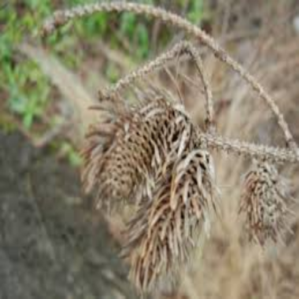

In [411]:
next(misclassified_images)

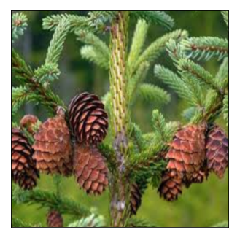

In [392]:
fig, ax = plt.subplots()

img = image.load_img('tree_photos/picea_sitchensis/image_sitka_spruce_cones_81.png', target_size=(299,299))
ax.imshow(img)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)